In [33]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms as t, models
from torch.utils.data import DataLoader, Dataset
import random
from tqdm.notebook import tqdm
import os
import cv2
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import wandb
import torchmetrics


In [2]:
# Fixed seeding

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
# Custom dataset class to get the image and its corresponding label

class Chest_Dataset(Dataset):
    def __init__(self, df, dir, transform=None):
        """
        Args:
            df (pd.DataFrame): dataframe that have the images names and labels
            dir (string): Directory of the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.dir = dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.dir, self.df.iloc[idx, 1])  # type: ignore

        image = np.load(image_path).astype(np.float32)

        labels = self.df.iloc[idx, 2:].values
        labels = labels.astype('float32')
        labels = torch.from_numpy(labels)
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample


In [38]:
# In this cell we will:
# 1. Read the train and validation csv files
# 2. Define batch size
# 3. Define transformers for training and validation
# 4. Define the datasets using the Chest_Dataset class
# 5. Define dataloaders to load the data as batches

train_df = pd.read_csv("./train_csv.csv")
train_df["Image Index"] = train_df["Image Index"].apply(lambda x: x.replace(".png", ".npy"))
valid_df = pd.read_csv("./valid_csv.csv")
valid_df["Image Index"] = valid_df["Image Index"].apply(lambda x: x.replace(".png", ".npy"))

train_dir = "./processed_images/train/"
valid_dir = "./processed_images/valid/"

batch_size = 32

transforms = {
    'train': t.Compose([t.ToTensor(),
                        t.Normalize(0.49, 0.248),
                        t.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                        t.RandomResizedCrop((224, 224), scale=(0.5, 1))]),
    'valid': t.Compose([t.ToTensor(),
                        t.Normalize(0.49, 0.248)])
}

datasets = {'train': Chest_Dataset(train_df, train_dir, transform=transforms['train']),
            'valid': Chest_Dataset(valid_df, valid_dir, transform=transforms['valid']),
}

dataloaders = {
    'train': DataLoader(datasets["train"], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(datasets["valid"], batch_size=batch_size),
}


In [5]:
# Function to show the images

def imshow(image, ax=None):
    image = image.numpy().transpose((1, 2, 0))
    image = image * 0.248 + 0.49
    image = np.clip(image, 0, 1)
    ax.imshow(image, cmap="gray") if ax else plt.imshow(image, cmap="gray")


c:\Users\user\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


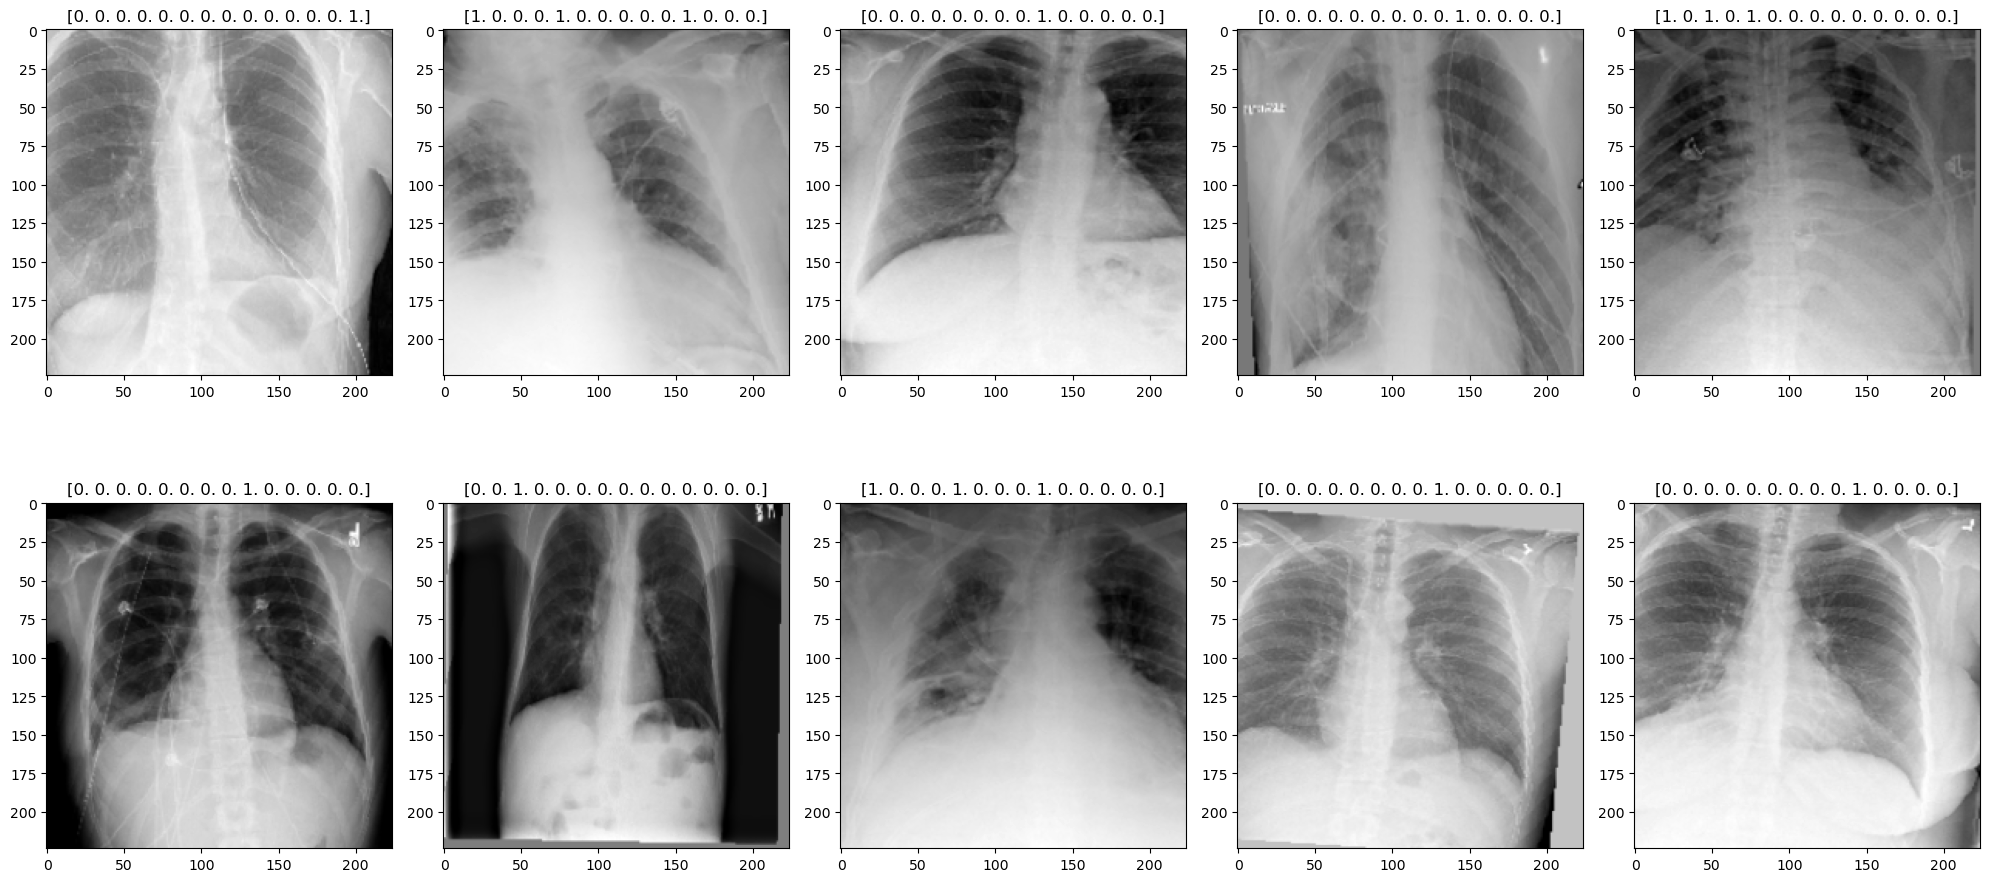

In [6]:
# Showing some images with their labels

images = next(iter(dataloaders['train']))

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    imshow(images["image"][i], ax)
    ax.set_title(images["labels"][i].numpy())

plt.tight_layout()


In [7]:
# Get the weights of each disease to set the weights in the loss function

weights = []

for label in train_df.columns[2:]:
    percentage = len(train_df[train_df[label] == 1]) / len(train_df)
    weights.append(1 // percentage)


In [25]:
# Define pytorch lightning class to handle training and validation processes

class Model(pl.LightningModule):
    def __init__(self, threshold):
        """
        function to define the model, loss function and evaluation metrics
        args:
            model_name (str): the name of the model to load it with timm library
            threshold  (float): number between 0 and 1 to pass it into the evaluation metrics
        """
        super().__init__()
        
        self.model = models.efficientnet_b4(weights='IMAGENET1K_V1')
        self.model.features[0][0] = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.model.classifier = nn.Sequential(nn.Linear(1792, 128, bias=False),
                                              nn.BatchNorm1d(128),
                                              nn.ReLU(),
                                              nn.Dropout(0.25),
                                              nn.Linear(128, 14))

        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(weights))

        self.accuracy = torchmetrics.classification.MultilabelAccuracy(14, threshold, average="macro")
        self.recall = torchmetrics.classification.MultilabelRecall(14, threshold, average="macro")
        self.precision_ = torchmetrics.classification.MultilabelPrecision(14, threshold, average="macro")
        self.specificity = torchmetrics.classification.MultilabelSpecificity(14, threshold, average="macro")

        self.metric_collection = torchmetrics.MetricCollection([
            self.accuracy,
            self.recall,
            self.precision_,
            self.specificity], prefix="val_")


    def forward(self, data):
        return self.model(data)


    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["labels"]
        pred = self(images)
        loss = self.criterion(pred, labels)

        self.log("train_loss", loss, on_epoch=True, on_step=False)

        return loss


    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["labels"]
        pred = self(images)
        loss = self.criterion(pred, labels)

        self.log("val_loss", loss, on_epoch=True, on_step=False)

        labels = labels.int()
        self.metric_collection.update(pred, labels)


    def test_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["labels"]
        labels = labels.int()
        pred = self(images)

        self.metric_collection.update(pred, labels)


    def on_validation_epoch_start(self):
        self.metric_collection.reset()


    def on_test_epoch_start(self):
        self.metric_collection.reset()


    def on_validation_epoch_end(self):
        self.log_dict(self.metric_collection.compute(), on_epoch=True, on_step=False)


    def on_test_epoch_end(self):
        print("\n")
        for key, value in self.metric_collection.compute().items():
            print(f"{key} = {value.item()}")


    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=5e-5)


In [9]:
# Define model object and checkpoints

model = Model(0.4)

checkpoint_accuracy = ModelCheckpoint(monitor="val_MultilabelAccuracy", save_top_k=1, mode="max", filename="max_accuracy_model")
checkpoint_recall = ModelCheckpoint(monitor="val_MultilabelRecall", save_top_k=1, mode="max", filename="max_recall_model")
checkpoint_precision = ModelCheckpoint(monitor="val_MultilabelPrecision", save_top_k=1, mode="max", filename="max_precision_model")
checkpoint_specificity = ModelCheckpoint(monitor="val_MultilabelSpecificity", save_top_k=1, mode="max", filename="max_specificity_model")
checkpoint_loss = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename="min_loss_model")

callbacks = [checkpoint_accuracy, checkpoint_recall, checkpoint_precision, checkpoint_specificity, checkpoint_loss]


In [10]:
# Initialize and log in to wandb

wandb.init(project="chest x-ray", entity="mohamed_raafat188")
wandb.login()
wandb_logger = WandbLogger(project="chest x-ray", name="attempt1")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mohamed_raafat188. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
c:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\loggers\wandb.py:345: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [11]:
# Define trainer object to handle training and validation process

gpus = 1
trainer = pl.Trainer(gpus=gpus, precision=16, logger=wandb_logger, log_every_n_steps=1, callbacks=callbacks, max_epochs=25)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
# Train and validate the model using the trainer object

trainer.fit(model, dataloaders['train'], dataloaders['valid'])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                  | Params
------------------------------------------------------------
0 | model             | EfficientNet          | 17.8 M
1 | criterion         | BCEWithLogitsLoss     | 0     
2 | accuracy          | MultilabelAccuracy    | 0     
3 | recall            | MultilabelRecall      | 0     
4 | precision_        | MultilabelPrecision   | 0     
5 | specificity       | MultilabelSpecificity | 0     
6 | metric_collection | MetricCollection      | 0     
------------------------------------------------------------
17.8 M    Trainable params
0         Non-trainable params
17.8 M    Total params
35.558    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
wandb.finish()


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_MultilabelAccuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
val_MultilabelPrecision,▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_MultilabelRecall,█▇▆▅▅▅▄▄▃▄▃▃▃▂▃▂▂▂▂▂▁▂▁▁▁
val_MultilabelSpecificity,▁▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▁▂▂▂▂▁▁▂▂▂▂
epoch,25
train_loss,0.86675
trainer/global_step,36399


In [26]:
model1 = Model.load_from_checkpoint("./chest x-ray/tqe623ye/checkpoints/max_accuracy_model.ckpt", threshold=0.4)
model2 = Model.load_from_checkpoint("./chest x-ray/tqe623ye/checkpoints/max_specificity_model.ckpt", threshold=0.4)
model3 = Model.load_from_checkpoint("./chest x-ray/tqe623ye/checkpoints/max_recall_model.ckpt", threshold=0.4)
model4 = Model.load_from_checkpoint("./chest x-ray/tqe623ye/checkpoints/max_precision_model.ckpt", threshold=0.4)
model5 = Model.load_from_checkpoint("./chest x-ray/tqe623ye/checkpoints/min_loss_model.ckpt", threshold=0.4)


In [17]:
trainer.test(model5, dataloaders=dataloaders["valid"])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]



val_MultilabelAccuracy = 0.578632116317749
val_MultilabelRecall = 0.8283613324165344
val_MultilabelPrecision = 0.17133942246437073
val_MultilabelSpecificity = 0.5328737497329712


[{}]

In [19]:
def predict(model, image_path):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = image / 255
    image = cv2.resize(image, (224, 224)).astype(np.float32)

    image = transforms["valid"](image).unsqueeze(0)
    pred = model(image)
    pred = torch.sigmoid(pred) > 0.5

    print(pred)


predict(model5, "../all_images/00030801_001.png")


tensor([[False, False, False, False, False,  True,  True, False,  True,  True,
          True,  True,  True, False]])
